In [1]:
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset,DataLoader
import numpy as np
import pandas as pd
import warnings
import time
import seaborn
from torch import nn
from typing import Optional,Union,List,Tuple
from torchvision import transforms
import re

#### 文本读取

In [2]:
# 读取语料
# 注意不要写到同一次读取操作中,readlines或者read中任意一个都会占用文件流导致另外一个失效
with open("timemachine.txt", 'r') as file:
    text_list = file.readlines()
with open("timemachine.txt", 'r') as file:
    text_str = file.read()


text_list[10],text_str[:100]

('twinkled, and his usually pale face was flushed and animated. The\n',
 'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Traveller (for so it will be convenient to ')

#### 文本预处理

In [3]:
# 利用正则表达式处理文本,将字母以外的标点符号替换为空格并都转换为小写
text_list = [re.sub('[^A-Za-z]+',' ',line).strip().lower() for line in text_list]
text_str = re.sub('[^A-Za-z]+',' ',text_str).strip().lower()
text_list[10], text_str[:100]

('twinkled and his usually pale face was flushed and animated the',
 'the time machine by h g wells i the time traveller for so it will be convenient to speak of him was ')

#### 构建词元

In [4]:
def tokenize(text:Union[List[str],str], token='word'):
    # 以单词作为词元
    if token=='word':
        if type(text) is list:
            return [line.split() for line in text]
        else:
            return text.split()
    # 以字符作为词元
    elif token=='char':
        if type(text) is list:
            return [list(line) for line in text]
        else:
            return list(text)
    else:
        raise TypeError("未知词元类型")

tokens_list_bychar = tokenize(text_list,'char')
tokens_str_bychar = tokenize(text_str,'char')
tokens_list_bychar[0]==tokens_str_bychar[:29]

True

In [5]:
tokens_list_byword = tokenize(text_list)
tokens_str_byword = tokenize(text_str)
tokens_list_byword[0]==tokens_str_byword[:7]

True

#### 构建词汇表,词元和索引之间的映射关系

In [6]:
from collections import Counter
class Vocab:
    def __init__(self, tokens:List, min_freq=0, reserved_tokens:List=[]) -> None:
        # 以字符作为词元时,tokens的形状应该为2维的list
        # 将2维列表拉直
        if tokens and isinstance(tokens[0],list):
            tokens = [char for line in tokens for char in line]
        # 计算每个char出现的频率
        counter = Counter(tokens)
        # 降序排列
        self.token_freqs = sorted(counter.items(),key=lambda x:x[1], reverse=True)
        # 制作词元索引
        # 语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元类  '<unk>(unknown token)'
        self.index_to_token = reserved_tokens + ['<unk>']
        # 词元token类映射到index
        self.token_to_index = {token: idx for idx,token in enumerate(self.index_to_token)}

        for token, freq in self.token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_index:
                # 将词元类添加到词元表中
                self.index_to_token.append(token)
                # token类映射到index的dict对应的token的index设置为 len - 1(即现索引的后一位)
                self.token_to_index[token] = len(self.index_to_token) - 1
    
    def __len__(self):
        return len(self.index_to_token)
    
    @property
    def unk(self):
        return self.token_to_index['<unk>']

    def __getitem__(self, tokens):
        # 重载[]运算符
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_index.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices,(list,tuple)) or isinstance(indices, slice):
            return self.index_to_token[indices]
        return [self.index_to_token[indice] for indice in indices]

# 构建训练和测试数据格式
def build(text, vocab=None, token='word', reserved_tokens=[]):
    tokens = tokenize(text, token)
    if vocab is None:
        vocab = Vocab(tokens,reserved_tokens=reserved_tokens)
    # 这里可以直接用tokens索引,但是当tokens是二维的时候需要额外拉直,故采用for创建
    corpus = [vocab[tk] for tk in tokens]
    return corpus, vocab

    

        

# 测试词元为char
temp = Vocab(tokens_list_bychar)
print(temp.token_freqs)
# temp = Vocab(tokens_str_bychar,reserved_tokens=['<pad>','<bos>'])
# print(temp['<unk>','<pad>'])# getitem
print(temp.to_tokens(slice(1,5)))
print(temp.to_tokens([1,4]))


[(' ', 29927), ('e', 17838), ('t', 13515), ('a', 11704), ('i', 10138), ('n', 9917), ('o', 9758), ('s', 8486), ('h', 8257), ('r', 7674), ('d', 6337), ('l', 6146), ('m', 4043), ('u', 3805), ('c', 3424), ('f', 3354), ('w', 3225), ('g', 3075), ('y', 2679), ('p', 2427), ('b', 1897), ('v', 1295), ('k', 1087), ('x', 236), ('z', 144), ('j', 97), ('q', 95)]
[' ', 'e', 't', 'a']
[' ', 'a']


In [7]:
# 测试word作为词元
temp = Vocab(tokens_list_byword)
print(temp.to_tokens(slice(1,5)), len(temp))

['the', 'i', 'and', 'of'] 4580


In [8]:
# 测试build函数功能
corpus,vocab = build(text_str)
len(corpus)

32775

#### Build RNN From Scratch

##### 数据的序列划分

In [9]:
# 编写测试dataloader
def get_dataloader(data:Union[torch.Tensor,List[torch.Tensor]], train:bool=True, n_train:Union[int,float]=0.8, batch_size:int=16):
    assert (type(data[0]) is torch.Tensor), "The data contains X,y which must be a Tensor"
    n_total = data[0].shape[0]
    if type(n_train) is float:
        n_train = int(n_total * n_train)
    
    indices = slice(0,n_train) if train else slice(n_train, None)

    tensors = [a[indices] for a in data]
    data = TensorDataset(*tensors)
    if train:
            return DataLoader(data, batch_size, shuffle=train)
    else:
        return DataLoader(data, n_total - n_train)

data = [torch.tensor(corpus[:-1]), torch.tensor(corpus[1:])]

for X,y in get_dataloader(data,train=False):
    print(X.shape, y.shape)
    break

torch.Size([6555]) torch.Size([6555])


In [10]:
# 准备训练数据集
def generate_sequences(corpus,n_step)->Tuple[torch.Tensor,torch.Tensor]:
    # 生成len(corpus)//n_step个长度为n_step的序列集合
    sequences = torch.tensor([corpus[i:i+n_step] for i in range(len(corpus)-n_step)],dtype=torch.int64)
    return sequences[:,:-1], sequences[:,1:]

train_X,train_y = generate_sequences(corpus,5)
print(train_X.shape)
for X,y in get_dataloader([train_X,train_y],train=True,batch_size=2):
    print(X,"\n", y)
    break

torch.Size([32770, 4])
tensor([[  21,   19,    1,   19],
        [  25, 2320,    1,   19]]) 
 tensor([[  19,    1,   19,   50],
        [2320,    1,   19,   71]])


##### 构建RNN网络

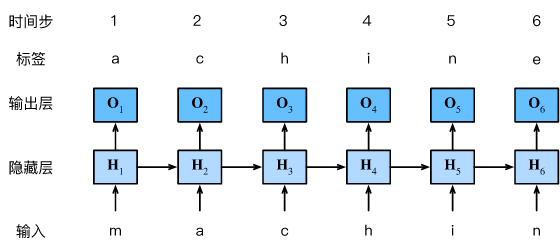<br>
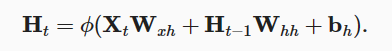
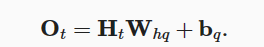

In [66]:
# 明确一下任务和理论
# 序列长度其实对应着RNN网络的隐藏层节点个数
# 损失的评价指标:困惑度
# 困惑度的求得需要one-hot编码
# 将二维原数据(batch_size, index)的对应vocabulary中的index进行独热编码后即可使其增加到三维-----------↓
# 于是我们需要的输出维度:(batch_size, len_sequence, vocab_onehot_vector)\(批量大小，序列长度, 词表的onehot vector)
# 为了更方便的遍历数据,通常转换为维度排列->(len_sequence, batch_size, vocab_onehot_vector)\(序列长度, 批量大小, 词表的onehot vector)
# 输入input的各个维度dimension:(len_sequence, batch_size, vocab_onehot_vector)
#                                                           ↓→->-> n_inputs

# 输入input传递到隐层时进行 X @ W_xh + state @ W_hh + b 运算,其中X @ W_xh对应维度(len_sequence, batch_size, n_hiddens)

# len(vocab) = n_inputs = n_outputs
# n_steps = len_sequences
#
# 隐藏层hidden_layer: 
# 1、store the state of last moment, dimension analysis:(n_hiddens, n_hiddens) ->输出形状:(len_sequence, batch_size, n_hiddens)
# 2、receive the input of now, dimension is same as last moment

# 输出output:形状需要与input一致

class MyRNN(nn.Module):
    def __init__(self, n_inputs, n_hiddens) -> None:
        super(MyRNN, self).__init__()
        # 计算隐层的权重和偏置
        self.n_inputs = n_inputs
        n_outputs = n_inputs
        self.n_hiddens = n_hiddens
        # 隐层共用权重
        self.w_xh = torch.rand(n_inputs, n_hiddens)
        self.w_hh = torch.rand(n_hiddens, n_hiddens)
        self.b_h = torch.zeros(n_hiddens)
        # 计算output的权重和偏置
        self.w_h = torch.rand(n_hiddens, n_outputs)
        self.b = torch.zeros(n_outputs)
    
    def forward_hidden(self,X:torch.Tensor, state=None)->List[torch.Tensor]:
        # 隐层的前向传播
        assert type(X) is torch.Tensor, "inputs X must be tensor type"
        
        H = []
        for x in X:
            state = torch.tanh(x @ self.w_xh  + state @ self.w_hh + self.b_h)
            H.append(state)
        return H

    def forward(self, X:torch.Tensor, state=None)->Tuple[List[torch.Tensor],torch.Tensor]:
        """

        Args:
            X (_type_): 当前时刻输入,维度排列需要为(序列长度, batch_size, len_vocab)
            state (_type_): 初始时刻的H1隐层state

        Returns:
            torch.Tensor
        """ 
        assert type(X) is torch.Tensor, "inputs X must be tensor type"
        # X若是二维的那么判定未做独热处理需要进行独热处理
        train_X = self.one_hot(X) if X.dim()==2 else X

        if state is None:
            state = torch.zeros(train_X.shape[1], self.n_hiddens)
        
        train_X = train_X.requires_grad_(True)
        output = [x @ self.w_h+self.b
                    for x in self.forward_hidden(train_X, state)]
        
        return torch.stack(output)
    
    def one_hot(self, X:torch.Tensor)->torch.Tensor:
        # 将输入变成one-hot编码形式
        # 输入X的维度排列:(batch_size, len_sequence)
        # 目标output X要求的维度排列为:(len_sequence, batch_size, len_vacob)
        # one-hot encoding: 2*1[0,2]->one-hot vector whose len=5 -> 2*5[[1,0,0,0,0],[0,0,1,0,0]]
        # 3*2 [[0,2],[0,2],[0,2]] -> 3*2*5 [[[1,0,0,0,0],[0,0,1,0,0]],[...],[...]]
        # 上述例子转置2*3 [[0,0,0][2,2,2]] -> 2*3
        # 需要操作:将X重排至(len_sequence, batch_size)
        X = X.type(dtype=torch.int64)
        return nn.functional.one_hot(X.T, self.n_inputs).type(torch.float32)
    
    def configure_optimizer(self,lr):
        return torch.optim.Adam([self.w_xh,self.w_hh, self.b_h, self.w_h, self.b], lr)
    
    def loss(self, y:torch.Tensor, y_hat:torch.Tensor)->torch.Tensor:
        l = nn.functional.cross_entropy(y_hat, y)
        return torch.exp(l)

    def fit(self, Data:List[torch.Tensor], epochs=5, batch_size=32, lr=0.001):
        optimizer = self.configure_optimizer(lr)
        for epoch in range(epochs):
            print(f"开始第{epoch+1}轮训练")
            loss_val = []
            for X,y in get_dataloader(Data,batch_size=batch_size):
                y = self.one_hot(y).requires_grad_(True)
                # print(self.one_hot(X)[0][0],y[0][0])
                # return
                optimizer.zero_grad()
                y_hat = self.forward(X)
                l = self.loss(y, y_hat)
                loss_val.append(l)
                # l.requires_grad_(True)
                l.backward()
                optimizer.step()
            with torch.no_grad():
                print("loss:", loss_val[-1])
                


batch_size, n_inputs, n_hiddens, n_steps = 2, 16, 32, 100
rnn = MyRNN(n_inputs, n_hiddens)

# test forward
temp = torch.ones((n_steps, batch_size, n_inputs))
outputs = rnn(temp)
len(outputs)==n_steps,outputs[0].shape

(True, torch.Size([2, 16]))

In [12]:
# test one-hot
# one-hot函数 官网文档中可以查到要求传入的tensor类型为long即int64
temp = torch.ones((batch_size, n_steps),dtype=torch.int64)# 2 * 100
rnn.one_hot(temp).shape,rnn.one_hot(temp).dtype# 100 * 2 * 16

(torch.Size([100, 2, 16]), torch.float32)

In [64]:
# del X,y,train_X,train_y
temp = list(np.arange(batch_size*n_steps)%16)
print(temp)
rnn.fit(generate_sequences(temp,n_steps),batch_size=1)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7]
开始第1轮训练
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SelectBackward0>)


In [ ]:
model = MyRNN(n_inputs=len(vocab), n_hiddens=100)
# 有点问题,loss一直稳定不咋更新,无论学习率,batch_size为何,不只是否是调用自动微分部分写的有问题
model.fit(generate_sequences(corpus[:3000],100),lr=0.5,batch_size=128)

#### 调用高级API实现

In [71]:
class RNNTorch():
    def __init__(self, n_inputs, n_hiddens) -> None:
        n_outputs = n_inputs
        self.rnn = nn.RNN(n_inputs,n_hiddens)
        self.fc = nn.Linear(n_hiddens, n_outputs)
    
    def forward(self, X:torch.Tensor, H=None):
        X = nn.functional.one_hot(X.T.long(), self.rnn.input_size)
        X = X.float()
        h,_ = self.rnn(X)
        return self.fc(h)

# test
model_rnn= RNNTorch(n_inputs, n_hiddens)

model_rnn.forward(torch.ones(batch_size, n_steps)).shape


torch.Size([100, 2, 16])